## Task 2: Regional Temperature Changes

### Preprocessing Data

In [36]:
#imports
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [37]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [38]:
gcs = gcsfs.GCSFileSystem(token='anon')

In [39]:
df_tas_hist=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1'")
df_tas_ssp585=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1'")

#  assemble a set of models (source_id) for each experiment + variable combination
models_tas_hist  =set(df_tas_hist.source_id)    # all models that have temperature in the historical simulations
models_tas_ssp585=set(df_tas_ssp585.source_id)  # all models that have temperature in the ssp585     simulations

# let's only keep the models that have all the runs (the intersection of the set)
source_set = set.intersection(models_tas_hist, models_tas_ssp585)
source_list=list(source_set)
print(len(models_tas_hist))
print(len(models_tas_ssp585))
print(len(source_list))

55
35
35


In [40]:
source_list.remove('MPI-ESM1-2-LR')
source_list.remove('MPI-ESM1-2-HR')
source_list.remove('AWI-CM-1-1-MR')
print(len(source_list))

32


In [41]:
source_list

['GFDL-ESM4',
 'INM-CM4-8',
 'IITM-ESM',
 'EC-Earth3-Veg-LR',
 'NESM3',
 'CAS-ESM2-0',
 'KACE-1-0-G',
 'CMCC-CM2-SR5',
 'CESM2-WACCM',
 'ACCESS-ESM1-5',
 'MIROC6',
 'CMCC-ESM2',
 'EC-Earth3',
 'FIO-ESM-2-0',
 'EC-Earth3-Veg',
 'ACCESS-CM2',
 'MRI-ESM2-0',
 'FGOALS-g3',
 'TaiESM1',
 'NorESM2-LM',
 'GFDL-CM4',
 'KIOST-ESM',
 'BCC-CSM2-MR',
 'CAMS-CSM1-0',
 'INM-CM5-0',
 'E3SM-1-1',
 'IPSL-CM6A-LR',
 'NorESM2-MM',
 'CanESM5',
 'CIESM',
 'EC-Earth3-CC',
 'FGOALS-f3-L']

In [42]:
def load_zarr_dset(df):
  # get the path to a specific zarr store (the first one from the dataframe above)
  zstore = df.zstore.values[-1]

  # create a mutable-mapping-style interface to the store
  mapper = gcs.get_mapper(zstore)

  # open it using xarray and zarr
  ds = xr.open_zarr(mapper, consolidated=True)
  return ds

In [43]:
#time index to assign model times to
new_time_index=pd.date_range('1850-01-01', '2099-12-31', freq='ME')
new_time_index

DatetimeIndex(['1850-01-31', '1850-02-28', '1850-03-31', '1850-04-30',
               '1850-05-31', '1850-06-30', '1850-07-31', '1850-08-31',
               '1850-09-30', '1850-10-31',
               ...
               '2099-03-31', '2099-04-30', '2099-05-31', '2099-06-30',
               '2099-07-31', '2099-08-31', '2099-09-30', '2099-10-31',
               '2099-11-30', '2099-12-31'],
              dtype='datetime64[ns]', length=3000, freq='ME')

In [44]:
#regrid to common 1x1 grid
new_lats=np.arange(-87,88)
new_lons=np.arange(1,359)

In [10]:
#access each of the models 
df_mpi_esm_hist = df.query(  "activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1' & source_id== 'MPI-ESM1-2-HR'")
df_awi_cm_hist =  df.query(  "activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1' & source_id== 'AWI-CM-1-1-MR'")
#load as xarray dataset
ds_mpi_esm_hist =load_zarr_dset(df_mpi_esm_hist)
ds_awi_cm_hist = load_zarr_dset(df_awi_cm_hist)

In [11]:
#attempt to mask ds_mpi_esm_hist by creating nan values from 1850-1-01 to 1915-01-16 (we might have to use diff time slicings with periods like before
start_date = np.datetime64('1850-01-01') #created start and end dates with same datetime timeseries as model
end_date = np.datetime64('1915-01-16')
#creates mask that is True for dates within range and False otherwise
#those within the range are marked as True to become masked as NaN
mask = (ds_mpi_esm_hist.time >= start_date) & (ds_mpi_esm_hist.time < end_date)
ds_mpi_esm_hist = ds_mpi_esm_hist.assign_coords(time=xr.where(mask, np.datetime64('NaT'), ds_mpi_esm_hist.time)) #if i remove the 3rd value in paraneth all values = NaT
list(ds_mpi_esm_hist.time.values)

[numpy.datetime64('1915-01-16T12:00:00.000000000'),
 numpy.datetime64('1915-02-15T00:00:00.000000000'),
 numpy.datetime64('1915-03-16T12:00:00.000000000'),
 numpy.datetime64('1915-04-16T00:00:00.000000000'),
 numpy.datetime64('1915-05-16T12:00:00.000000000'),
 numpy.datetime64('1915-06-16T00:00:00.000000000'),
 numpy.datetime64('1915-07-16T12:00:00.000000000'),
 numpy.datetime64('1915-08-16T12:00:00.000000000'),
 numpy.datetime64('1915-09-16T00:00:00.000000000'),
 numpy.datetime64('1915-10-16T12:00:00.000000000'),
 numpy.datetime64('1915-11-16T00:00:00.000000000'),
 numpy.datetime64('1915-12-16T12:00:00.000000000'),
 numpy.datetime64('1916-01-16T12:00:00.000000000'),
 numpy.datetime64('1916-02-15T12:00:00.000000000'),
 numpy.datetime64('1916-03-16T12:00:00.000000000'),
 numpy.datetime64('1916-04-16T00:00:00.000000000'),
 numpy.datetime64('1916-05-16T12:00:00.000000000'),
 numpy.datetime64('1916-06-16T00:00:00.000000000'),
 numpy.datetime64('1916-07-16T12:00:00.000000000'),
 numpy.datet

In [12]:
#attempt to mask ds_mpi_esm_hist by creating nan values from 1850-1-01 to 1851-01-16 (we might have to use diff time slicings with periods like before
start_date = np.datetime64('1850-01-01') #created start and end dates with same datetime timeseries as model
end_date = np.datetime64('1851-01-16')
#creates mask that is True for dates within range and False otherwise
#those within the range are marked as True to become masked as NaN
mask = (ds_awi_cm_hist.time >= start_date) & (ds_awi_cm_hist.time < end_date)
ds_awi_cm_hist = ds_awi_cm_hist.assign_coords(time=xr.where(mask, np.datetime64('NaT'), ds_awi_cm_hist.time)) #if i remove the 3rd value in paraneth all values = NaT
list(ds_awi_cm_hist.time.values)

[numpy.datetime64('1851-01-16T12:00:00.000000000'),
 numpy.datetime64('1851-02-15T00:00:00.000000000'),
 numpy.datetime64('1851-03-16T12:00:00.000000000'),
 numpy.datetime64('1851-04-16T00:00:00.000000000'),
 numpy.datetime64('1851-05-16T12:00:00.000000000'),
 numpy.datetime64('1851-06-16T00:00:00.000000000'),
 numpy.datetime64('1851-07-16T12:00:00.000000000'),
 numpy.datetime64('1851-08-16T12:00:00.000000000'),
 numpy.datetime64('1851-09-16T00:00:00.000000000'),
 numpy.datetime64('1851-10-16T12:00:00.000000000'),
 numpy.datetime64('1851-11-16T00:00:00.000000000'),
 numpy.datetime64('1851-12-16T12:00:00.000000000'),
 numpy.datetime64('1852-01-16T12:00:00.000000000'),
 numpy.datetime64('1852-02-15T12:00:00.000000000'),
 numpy.datetime64('1852-03-16T12:00:00.000000000'),
 numpy.datetime64('1852-04-16T00:00:00.000000000'),
 numpy.datetime64('1852-05-16T12:00:00.000000000'),
 numpy.datetime64('1852-06-16T00:00:00.000000000'),
 numpy.datetime64('1852-07-16T12:00:00.000000000'),
 numpy.datet

### 2.1 Analysis for One Model

In [25]:
#query data
df_tas_hist_canesm5=df.query  ("activity_id=='CMIP' & source_id == 'CanESM5' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1'")
df_tas_ssp585_canesm5=df.query("activity_id=='ScenarioMIP' & source_id == 'CanESM5' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1'")
#load data
ds_hist_tas_canesm5 = load_zarr_dset(df_tas_hist_canesm5)
ds_ssp585_tas_canesm5 = load_zarr_dset(df_tas_ssp585_canesm5)
#compute diff between avg over years 2089-2099 and 1989-1999
hist_tas_canesm5 = ds_hist_tas_canesm5.sel(time=slice('1989','1999'))
ssp585_tas_canesm5 = ds_ssp585_tas_canesm5.sel(time=slice('2089','2099'))
#dtas = ssp585_tas_canesm5_w_mean.mean('time') - hist_tas_canesm5_w_mean.mean('time') this doesn't work
dtas = ssp585_tas_canesm5.tas.mean('time')-hist_tas_canesm5.tas.mean('time') #i'm not accessing the weights 
dtas

<xarray.DataArray 'tas' (lat: 64, lon: 128)>
dask.array<sub, shape=(64, 128), dtype=float32, chunksize=(64, 128), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2

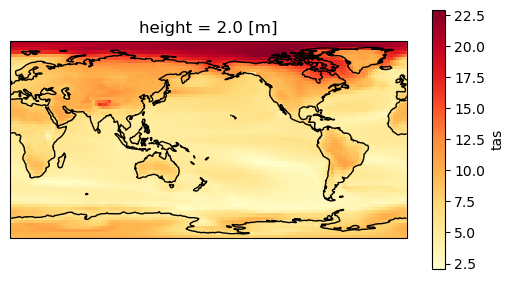

In [26]:
#plot of dtas using cartopy, map of regional warming over the 21st century
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 180))
ax.coastlines()
dtas.plot(ax=ax, cmap = "YlOrRd", transform = ccrs.PlateCarree(), cbar_kwargs = {"shrink": 0.7})

### 2.2 Multiple Models

In [11]:
gcm_list = ['KIOST-ESM',
 'CanESM5',
 'EC-Earth3-Veg',
 'CMCC-CM2-SR5',
 'CMCC-ESM2']

In [12]:
#load multiple models
ds_list = list()
for source in gcm_list:
    df_hist_tas=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1' & source_id== @source")
    df_ssp585_tas=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1' & source_id== @source")
    ds_hist_tas   =load_zarr_dset(df_hist_tas)
    ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
    #nan time values models
    #if source == 'MPI-ESM1-2-HR':
        #ds_hist_tas = ds_mpi_esm_hist
    #if source == 'AWI-CM-1-1-MR':
        #ds_hist_tas = ds_awi_cm_hist
    #compute difference between avg over years 2089-2099 and years 1989-1999
    hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
    ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
    dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
    ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
    ds_interp.assign_coords(model = source)
    print(ds_interp)
    ds_list.append(ds_interp)
    #print(ds_list)
gcm_obs = xr.concat(ds_list, dim = 'model', coords = 'minimal',compat='override')
gcm_obs

<xarray.DataArray 'tas' (lat: 175, lon: 358)>
dask.array<chunked_aware_interpnd, shape=(175, 358), dtype=float32, chunksize=(175, 358), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
<xarray.DataArray 'tas' (lat: 175, lon: 358)>
dask.array<chunked_aware_interpnd, shape=(175, 358), dtype=float32, chunksize=(175, 358), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
<xarray.DataArray 'tas' (lat: 175, lon: 358)>
dask.array<chunked_aware_interpnd, shape=(175, 358), dtype=float32, chunksize=(175, 358), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6

<xarray.DataArray 'tas' (model: 5, lat: 175, lon: 358)>
dask.array<concatenate, shape=(5, 175, 358), dtype=float32, chunksize=(1, 175, 358), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
    height   float64 2.0
Dimensions without coordinates: model

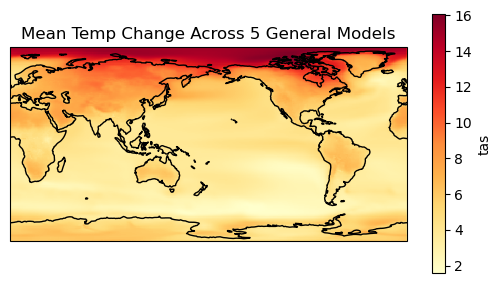

In [14]:
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 180))
ax.coastlines()
gcm_obs_mean = gcm_obs.mean(dim='model') #took mean across models to eliminate one dimension and mash all model data tg -> 2D now
gcm_obs_mean.plot(ax=ax, cmap = "YlOrRd", transform = ccrs.PlateCarree(), cbar_kwargs = {"shrink": 0.7})
plt.title('Mean Temp Change Across 5 General Models')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.show()

In [48]:
#or i could isel by periods like before (both 10 years)
#and then i could set new_time_index for both of them like in global (same process, diff starts and ends)
#hopefully this process sorts the index out otherwise we need to find another way
#Error: KeyError: 'Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is not allowed.'
hist_time_index = pd.date_range('1989-01-01', '1998-12-31', freq = 'ME')
ssp585_time_index = pd.date_range('2089-01-01', '2098-12-31', freq = 'ME')
#assign is invalid? do we need this?

In [19]:
hist_time_index

DatetimeIndex(['1989-01-31', '1989-02-28', '1989-03-31', '1989-04-30',
               '1989-05-31', '1989-06-30', '1989-07-31', '1989-08-31',
               '1989-09-30', '1989-10-31',
               ...
               '1998-03-31', '1998-04-30', '1998-05-31', '1998-06-30',
               '1998-07-31', '1998-08-31', '1998-09-30', '1998-10-31',
               '1998-11-30', '1998-12-31'],
              dtype='datetime64[ns]', length=120, freq='ME')

In [61]:
#Things that I've tried so far
#same method as slicing the time values with str with general models but i get the keyerror
#Accessing isel + assigning new time coords (only creates wrong valued figure with low tas)
#Accessing only isel = same result as assigning new coords i think
#Making it into a dataset without accessing tas (leaving it as a variable) -> no difference really
######
#problems were created after I put the two extra models in -> i wrote nats for the nonexistent times and put conditionals in for loop
#the 5 general models work fine and it worked fine before i put the extra two models in -> they could be the problem or my code isnt compatible with the model times or smth
##based off the keyerror, i could try sorting the time values if they're out of order

Nonmonotomic = not increasing or decreasing in strict order -> solution = sortby

Problem: Keyerror with datetime partial slicing on non-monotonic datetimeindexes with non-existing keys is not allowed

Attempted solutions:
- sortby = same keyerror
- with 2 models = error occurs before AND after NaNs
- isel = no error but have incorrect values/figures for tas
- isel + assigning did the same as just isel

Possible reasoning: 
- i didnt create the nan values properly or the xarray dataset isn't recognizing it as NaNs so they see them as missing

In [45]:
ds_list = list()
for source in source_list:
    df_hist_tas=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1' & source_id== @source")
    df_ssp585_tas=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1' & source_id== @source")
    ds_hist_tas   =load_zarr_dset(df_hist_tas)
    ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
    #conditionals for nan time values models
    #if source == 'MPI-ESM1-2-HR':
        #ds_hist_tas = ds_mpi_esm_hist
    #elif source == 'AWI-CM-1-1-MR':
        #ds_hist_tas = ds_awi_cm_hist
    #compute difference between avg over years 2089-2099 and years 1989-1999
    #hist_tas = ds_hist_tas.isel(time=slice(0,120))
    #ssp585_tas = ds_ssp585_tas.isel(time=slice(0,120))
    #hist_tas = hist_tas.assign(time=hist_time_index)
    #ssp585_tas = ssp585_tas.assign(time=ssp585_time_index)
    #sortby time variable into ascending order
    #ds_hist_tas = ds_hist_tas.sortby("time")
    #ds_ssp58_tas = ds_ssp585_tas.sortby("time")
    hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
    ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
    dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
    ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
    ds_interp= ds_interp.assign_coords(model = source)
    #print(ds_interp)
    ds_list.append(ds_interp)
ds_all_reg = xr.concat(ds_list, dim = 'model', coords = 'minimal',compat='override')
ds_all_reg

C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\coding\times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\core\indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\codin

<xarray.DataArray 'tas' (model: 32, lat: 175, lon: 358)>
dask.array<concatenate, shape=(32, 175, 358), dtype=float32, chunksize=(1, 175, 358), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
  * model    (model) <U16 'GFDL-ESM4' 'INM-CM4-8' ... 'FGOALS-f3-L'

#### Adding 12 More Models

In [47]:
#make a separate list to concat with ds_all_reg
ds_12_models_list = list()
#query to individual model
df_hist_tas = df.query(  "source_id == 'CNRM-CM6-1' & member_id == 'r2i1p1f2' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'CNRM-CM6-1' & member_id == 'r2i1p1f2' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load model as dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [48]:
#query to individual model
df_hist_tas = df.query(  "source_id == 'GISS-E2-1-G' & member_id == 'r2i1p1f2' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'GISS-E2-1-G' & member_id == 'r2i1p1f2' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load model as dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [49]:
#query to individual model
df_hist_tas = df.query(  "source_id == 'CanESM5-CanOE' & member_id == 'r1i1p2f1' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'CanESM5-CanOE' & member_id == 'r1i1p2f1' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load model as dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [50]:
#query to individual model
df_hist_tas = df.query(  "source_id == 'MCM-UA-1-0'  & member_id == 'r1i1p1f2' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'MCM-UA-1-0' & member_id == 'r1i1p1f2' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#concat data
#rename latitude and longitude to lat/lon for consistency
ds_hist_tas = ds_hist_tas.rename({'latitude': 'lat', 'longitude': 'lon'})
ds_ssp585_tas = ds_ssp585_tas.rename({'latitude': 'lat', 'longitude': 'lon'})
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [51]:
df_hist_tas = df.query(  "source_id == 'MIROC-ES2L'  & member_id == 'r1i1p1f2' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'MIROC-ES2L'  & member_id == 'r1i1p1f2' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [52]:
df_hist_tas = df.query(  "source_id == 'GISS-E2-1-H'  & member_id == 'r1i1p1f2' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'GISS-E2-1-H'  & member_id == 'r1i1p1f2' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [53]:
df_hist_tas = df.query(  "source_id == 'CNRM-CM6-1-HR'  & member_id == 'r1i1p1f2' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'CNRM-CM6-1-HR'  & member_id == 'r1i1p1f2' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [54]:
df_hist_tas = df.query(  "source_id == 'UKESM1-0-LL'  & member_id == 'r1i1p1f2' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'UKESM1-0-LL'  & member_id == 'r1i1p1f2' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [55]:
df_hist_tas = df.query(  "source_id == 'HadGEM3-GC31-LL'  & member_id == 'r1i1p1f3' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'HadGEM3-GC31-LL'  & member_id == 'r1i1p1f3' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [56]:
df_hist_tas = df.query(  "source_id == 'CESM2'  & member_id == 'r4i1p1f1' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'CESM2'  & member_id == 'r4i1p1f1' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
#load in data into dataset
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [57]:
df_hist_tas = df.query(  "source_id == 'HadGEM3-GC31-MM'  & member_id == 'r1i1p1f3' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'HadGEM3-GC31-MM'  & member_id == 'r1i1p1f3' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [58]:
df_hist_tas = df.query(  "source_id == 'CNRM-ESM2-1'  & member_id == 'r2i1p1f2' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'CNRM-ESM2-1'  & member_id == 'r2i1p1f2' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [59]:
df_hist_tas = df.query(  "source_id == 'MPI-ESM1-2-HR'  & member_id == 'r2i1p1f1' & activity_id=='CMIP'        & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'")
df_ssp585_tas = df.query("source_id == 'MPI-ESM1-2-HR'  & member_id == 'r2i1p1f1' & activity_id=='ScenarioMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'")
ds_hist_tas   =load_zarr_dset(df_hist_tas)
ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
#slicing and taking diff
hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
ds_interp = dtas.interp(lat = new_lats, lon = new_lons)
ds_interp= ds_interp.assign_coords(model = ds_hist_tas.source_id)
#print(ds_interp)
ds_12_models_list.append(ds_interp)

In [60]:
ds_12_models = xr.concat(ds_12_models_list, dim = 'model', coords = 'minimal', compat = 'override')
ds_12_models = ds_12_models.drop_vars('height')
ds_12_models

<xarray.DataArray 'tas' (model: 13, lat: 175, lon: 358)>
dask.array<concatenate, shape=(13, 175, 358), dtype=float32, chunksize=(1, 175, 358), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
  * model    (model) <U15 'CNRM-CM6-1' 'GISS-E2-1-G' ... 'MPI-ESM1-2-HR'

In [64]:
ds_all_45 = xr.concat([ds_12_models, ds_all_reg], dim = 'model', coords = 'minimal', compat = 'override')
ds_all_45 = ds_all_45.drop_vars('height')
ds_all_45

<xarray.DataArray 'tas' (model: 45, lat: 175, lon: 358)>
dask.array<concatenate, shape=(45, 175, 358), dtype=float32, chunksize=(1, 175, 358), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) int32 -87 -86 -85 -84 -83 -82 -81 ... 81 82 83 84 85 86 87
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 ... 351 352 353 354 355 356 357 358
  * model    (model) <U16 'CNRM-CM6-1' 'GISS-E2-1-G' ... 'FGOALS-f3-L'

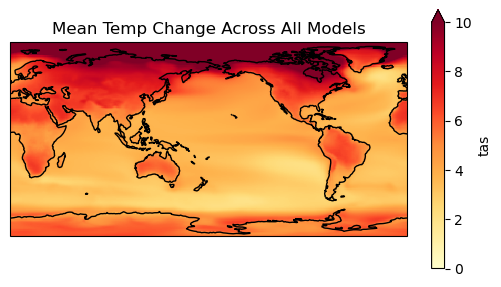

In [65]:
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 180))
ax.coastlines()
ds_all_reg_mean = ds_all_45.mean(dim='model') #took mean across models
img = ds_all_reg_mean.plot(ax=ax, cmap = "YlOrRd", transform = ccrs.PlateCarree(), vmin = 0, vmax = 10, cbar_kwargs = {"shrink": 0.7})
img.colorbar.set_ticks(np.arange(0,12,2))
plt.title('Mean Temp Change Across All Models')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.show()

In [66]:
#is it computing the NaT values as 0? it shouldnt matter bc the time we're slicing shouldn't have NaT values

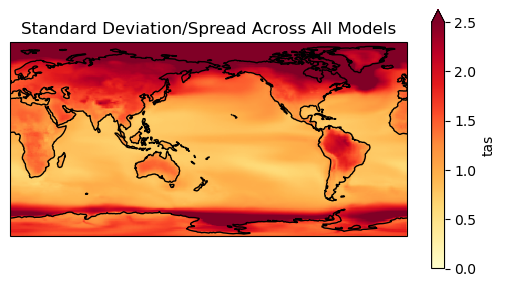

In [67]:
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 180))
ax.coastlines()
ds_all_reg_std = ds_all_45.std(dim='model') #took mean across models
img = ds_all_reg_std.plot(ax=ax, cmap = "YlOrRd", transform = ccrs.PlateCarree(), vmin=0, vmax=2.5, cbar_kwargs = {"shrink": 0.7})
img.colorbar.set_ticks([0, 0.5, 1.0, 1.5, 2.0, 2.5])
plt.title('Standard Deviation/Spread Across All Models')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.show()

In [68]:
#saving to netcdf file
ds_all_45.to_netcdf("processed_tas_regional_data.nc", mode = 'w', format = "NETCDF4", engine = 'netcdf4')